In [2]:
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt

%matplotlib inline

In [114]:
teams = [0, 1, 2, 3, 4]
n_teams = len(teams)

In [115]:
true_skill = {
    0: 0.0,
    1: 3.0,
    2: -3.0,
    3: 3.0,
    4: -1.0,
}

In [116]:
n_games = 400
games = range(n_games)
teamAWon = []
teamA = []
teamB = []
for game in games:
    game_database = {}
    matchup = np.random.choice(teams, size=2, replace=False)
    teamA.append(matchup[0])
    teamB.append(matchup[1])
    
#     true_skills = [true_skill[matchup[0]], true_skill[matchup[1]]]
    
    deltaRating = true_skill[matchup[0]] - true_skill[matchup[1]]

    p = 1 / (1 + np.exp(-deltaRating))

    randomNumber = np.random.random()

    outcome_A = p > randomNumber
#     game_skills = np.random.normal(loc=true_skills, scale=100)
    
#     outcome_A = game_skills[0] > game_skills[1]
    teamAWon.append(int(outcome_A))
    
simulated_data = {
    "teamsA": teamA,
    "teamsB": teamB,
    "teamAWon": teamAWon,
    "nTeams": n_teams,
    "nGames": n_games
}

In [117]:
results = pd.DataFrame(simulated_data)

In [118]:
results.head()

,nGames,nTeams,teamAWon,teamsA,teamsB
0,400,5,1,1,0
1,400,5,1,1,2
2,400,5,0,2,4
3,400,5,1,3,1
4,400,5,1,0,4


In [126]:
results.to_csv("results-artificial.csv")

In [119]:
groupedByA = results.groupby(['teamsA', 'teamsB']).sum().drop(['nTeams'], axis=1)

In [120]:
groupedByA["nGames"] = groupedByA["nGames"] / n_games

In [121]:
groupedByA

nGames  teamAWon
teamsA teamsB                  
0      1         15.0         1
       2         20.0        20
       3         19.0         0
       4         18.0        14
1      0         22.0        22
       2         20.0        20
       3         23.0        10
       4         21.0        21
2      0         17.0         2
       1         15.0         0
       3         21.0         0
       4         23.0         4
3      0         22.0        22
       1         21.0         9
       2         19.0        19
       4         22.0        22
4      0         23.0         7
       1         22.0         0
       2         16.0        15
       3         21.0         0

In [109]:
ratings_code = """
data {
    int<lower=1> nTeams; // number of teams in the league
    int<lower=1> nGames; // number of games in the database
    int<lower=0,upper=1> teamAWon[nGames]; // vector of binary outcomes for team A
    int<lower=0> teamsA[nGames];
    int<lower=0> teamsB[nGames];
}
parameters {
    vector[nTeams] teamSkill; // vector of team skills
}
model {
  real skillDelta[nGames];
  for (team in 1:nTeams)
    teamSkill[team] ~ normal(0, 1);
    
  for (game in 1:nGames) {
    int indexA;
    int indexB;
    indexA = teamsA[game] + 1;
    indexB = teamsB[game] + 1;
    skillDelta[game] = teamSkill[indexA] - teamSkill[indexB];
  }
  teamAWon ~ bernoulli_logit(skillDelta);
}
"""

In [122]:
sm = pystan.StanModel(model_code=ratings_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85448368721b7e30f6639f4bc2a64d09 NOW.


In [123]:
fit = sm.sampling(data=simulated_data, iter=2000, chains=4)

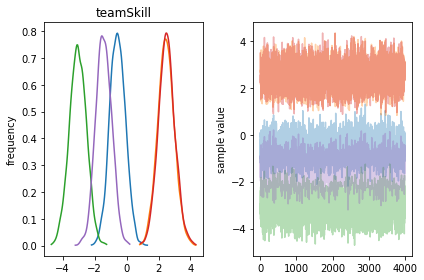

In [124]:
fit.plot()
plt.tight_layout()

In [125]:
print(fit)

Inference for Stan model: anon_model_85448368721b7e30f6639f4bc2a64d09.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
teamSkill[0]  -0.56    0.01   0.48  -1.51  -0.89  -0.56  -0.23   0.41   1330    1.0
teamSkill[1]   2.47    0.01   0.52   1.47   2.13   2.47   2.81    3.5   1411    1.0
teamSkill[2]  -3.04    0.01   0.53  -4.09   -3.4  -3.05  -2.68  -2.03   1367    1.0
teamSkill[3]   2.51    0.01   0.52   1.51   2.17    2.5   2.84   3.56   1447    1.0
teamSkill[4]  -1.42    0.01   0.49  -2.36  -1.75  -1.43  -1.09  -0.47   1352    1.0
lp__         -100.6    0.04   1.56 -104.3 -101.3 -100.2 -99.47 -98.53   1780    1.0

Samples were drawn using NUTS at Tue May 15 11:30:37 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [83]:
fit.flatnames

['teamSkill[0]', 'teamSkill[1]', 'teamSkill[2]']

In [87]:
fit.get_inits()

[OrderedDict([('teamSkill', array([-1.41927736, -1.07636329,  0.59449862]))]),
 OrderedDict([('teamSkill', array([-1.84594241,  1.83262095, -0.92086792]))]),
 OrderedDict([('teamSkill', array([ 0.21140071, -1.79929154, -0.15620837]))]),
 OrderedDict([('teamSkill', array([ 1.81811319,  0.11926067, -1.23340849]))])]

In [95]:
print(fit.get_stancode())


data {
    int<lower=1> nTeams; // number of teams in the league
    int<lower=1> nGames; // number of games in the database
    int<lower=0,upper=1> teamAWon[nGames]; // vector of binary outcomes for team A
    int<lower=0> teamsA[nGames];
    int<lower=0> teamsB[nGames];
}
parameters {
    vector[nTeams] teamSkill; // vector of team skills
}
model {
  real skillDelta[nGames];
  for (team in 1:nTeams)
    teamSkill[team] ~ normal(0, 1);
    
  for (game in 1:nGames) {
    int indexA;
    int indexB;
    indexA = teamsA[game] + 1;
    indexB = teamsB[game] + 1;
    skillDelta[game] = teamSkill[indexB] - teamSkill[indexA];
  }
  teamAWon ~ bernoulli_logit(skillDelta);
}

